<h2>Connect to the database</h2>

In [ ]:
import psycopg2

db_login = {
    'database': 'basketball',
    'user': 'globetrotter',
    'password': 'alpacaalpaca',
    'host': 'blaskey.dev',
    'port': 5432
}
conn = psycopg2.connect(**db_login)
cur = conn.cursor()

/usr/local/lib/python3.7/dist-packages/psycopg2/__init__.py:144: UserWarning: The psycopg2 wheel package will be renamed from release 2.8; in order to keep installing from binary please use "pip install psycopg2-binary" instead. For details see: <http://initd.org/psycopg/docs/install.html#binary-install-from-pypi>.
  """)


<h2>Get all games data</h2>

<p>We are only going to consider game data for our reinforcement betting bot. There should be more than enough data with just the game data for some patterns to be learned. Adding in player data would add a lot more complexity to the model.</p>

In [ ]:
cur.execute("SELECT * FROM game ORDER BY game_date") # ordered by past -> present
games_data_raw = []
for i in cur.fetchall():
  games_data_raw.append(i)

print("Got", len(games_data_raw), "games")
for i in games_data_raw[:10]: # View a sample of the data
  print(i)

Got 24146 games
(10300001, datetime.date(2003, 10, 5), 1610612762, 1610612742, 2003, True, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, False, False)
(10300002, datetime.date(2003, 10, 6), 1610612763, 1610612749, 2003, True, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, False, False)
(10300010, datetime.date(2003, 10, 7), 1610612764, 1610612752, 2003, True, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, False, False)
(10300006, datetime.date(2003, 10, 7), 1610612747, 1610612744, 2003, False, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, False, False)
(10300003, datetime.date(2003, 10, 7), 1610612765, 1610612739, 2003, False, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, False, False)
(10300004, datetime.date(2003, 10, 7), 1610612742, 161061

<h2>Put the games data into a pandas dataframe for processing<h2>

In [ ]:
import pandas as pd 

cols = ["game_id", "game_date", "home_team_id", "away_team_id", "season", "home_team_won", 
        "home_first", "home_second", "home_third", "home_fourt", "home_open", "home_close", "home_ml", "home_two_h",
        "away_first", "away_second", "away_third", "away_fourt", "away_open", "away_close", "away_ml", "away_two_h",
        "home_won_last", "away_won_last"]
game_data = pd.DataFrame(games_data_raw, columns = cols)

<h2>Cleansings</h2>

There are two aspects of missing data. Games with bettings odds we couldn't find, this is represented as the entire odds data being null.

The second is games with betting odds of "Pick Em". This is also represented as a null but the entire row will not be null. Pick Em means each team is equally favored to win (or a moneyline of +100, we will get into what exactly moneyline means later).

In [ ]:
betting_cols = cols[6:22]
home_betting_cols = betting_cols[:len(betting_cols) // 2]
away_betting_cols = betting_cols[len(betting_cols) // 2:]

home_betting_cols, away_betting_cols

(['home_first',
  'home_second',
  'home_third',
  'home_fourt',
  'home_open',
  'home_close',
  'home_ml',
  'home_two_h'],
 ['away_first',
  'away_second',
  'away_third',
  'away_fourt',
  'away_open',
  'away_close',
  'away_ml',
  'away_two_h'])

In [ ]:
# Drop games with all missing home betting odds
cleansed_game_data = game_data.dropna(subset = home_betting_cols, how = "all")
# Drop games with all missing away betting odds
cleansed_game_data = cleansed_game_data.dropna(subset = away_betting_cols, how = "all")

In [ ]:
# Replace pick ems with value of 100 
cleansed_game_data = cleansed_game_data.fillna(100)

cols_to_drop = betting_cols.copy()
cols_to_drop.remove("home_ml")
cols_to_drop.remove("away_ml")

cleansed_game_data.drop(cols_to_drop, axis = 1)

,game_id,game_date,home_team_id,away_team_id,season,home_team_won,home_ml,away_ml,home_won_last,away_won_last
5927,20700239,2007-12-01,1610612741,1610612766,2007,True,-325.0,275.0,True,False
5928,20700240,2007-12-01,1610612749,1610612765,2007,False,190.0,-230.0,False,True
5930,20700241,2007-12-01,1610612758,1610612745,2007,True,220.0,-260.0,False,False
5931,20700235,2007-12-01,1610612764,1610612761,2007,True,-155.0,135.0,False,True
5932,20700237,2007-12-01,1610612763,1610612750,2007,True,-450.0,370.0,False,False
...,...,...,...,...,...,...,...,...,...,...
24046,22000552,2021-03-04,1610612738,1610612761,2020,True,-365.0,305.0,True,False
24047,22000554,2021-03-04,1610612764,1610612746,2020,True,235.0,-275.0,False,False
24048,22000553,2021-03-04,1610612754,1610612743,2020,False,150.0,-170.0,True,True
24049,22000555,2021-03-04,1610612763,1610612749,2020,False,200.0,-240.0,True,False


<h2>What is a moneyline?</h2>

A negative money line is what you need to bet to win $100

A positive moneyline is what you win if you bet $100.

Example 
lakers -140
celtics +175

A \$140 bet on the lakers would mean you have \$240 (the \$140 you started with and the \$100 you won).

A \$100 bet on the celtics would mean you have \$275 (the \$100 you started with and the \$175 you won).

[Source](https://www.oddsshark.com/sports-betting/betting-money-line)

<h2>How to convert moneyline to something more sensable</h2>

[Source](https://www.gamingtoday.com/tools/moneyline/)

In [ ]:
def get_return(ml, bet_amount): # Returns the profit + bet_amount.
  if ml < 0:
    return (100 / -ml) * bet_amount + bet_amount
  return (ml / 100) * bet_amount + bet_amount
print(get_return(-165, 50), get_return(+140, 50))
print(get_return(-140, 140), get_return(+175, 100))

80.30303030303031 120.0
240.0 275.0


<h2>For fun, lets test out some betting strategies</h2>


In [ ]:
def test_best_strat(should_bet_on_home, bet_amount = 100):
  season = cleansed_game_data.iloc[0]["season"]

  bets_on_home, wins_on_home, home_win_amount = 0, 0, 0
  bets_on_away, wins_on_away, away_win_amount = 0, 0, 0

  seasons = []
  bets_on_homes, wins_on_homes, home_win_amounts = [], [], []
  bets_on_aways, wins_on_aways, away_win_amounts = [], [], []
  for game in cleansed_game_data.iterrows():
    if game[1]["season"] != season:
      seasons.append(season)
      bets_on_homes.append(bets_on_home)      
      wins_on_homes.append(wins_on_home)
      home_win_amounts.append(home_win_amount)

      bets_on_aways.append(bets_on_away)
      wins_on_aways.append(wins_on_away)   
      away_win_amounts.append(away_win_amount)

      season = game[1]["season"]
      bets_on_home, wins_on_home, home_win_amount = 0, 0, 0
      bets_on_away, wins_on_away, away_win_amount = 0, 0, 0

    if should_bet_on_home(game[1]):
      bets_on_home += 1
      if game[1]["home_team_won"]:
        wins_on_home += 1
        home_win_amount += get_return(game[1]["home_ml"], bet_amount)

    else:
      bets_on_away += 1
      if not game[1]["home_team_won"]:
        wins_on_away += 1
        away_win_amount += get_return(game[1]["away_ml"], bet_amount)

  seasons.append(season)
  bets_on_homes.append(bets_on_home)      
  wins_on_homes.append(wins_on_home)
  home_win_amounts.append(home_win_amount)

  bets_on_aways.append(bets_on_away)
  wins_on_aways.append(wins_on_away)   
  away_win_amounts.append(away_win_amount)

  total_spent = 0
  total_profit = 0
  for i in range(len(seasons)):
    amount_spent = (bets_on_homes[i] + bets_on_aways[i]) * bet_amount
    profit = home_win_amounts[i] + away_win_amounts[i] - amount_spent
    print(f"""season {seasons[i]} amount spent {amount_spent} profit {profit}
          home bets_placed {bets_on_homes[i]} bets_won {wins_on_homes[i]} amount_won {home_win_amounts[i]} 
          away bets_placed {bets_on_aways[i]} bets_won {wins_on_aways[i]} amount_won {away_win_amounts[i]}\n""")
    
    total_spent += amount_spent
    total_profit += profit

  print(f"""Total amount spent {total_spent} total profit {total_profit}""")


<h2>Let's always bet $100 on the home team</h2>

In [ ]:
def always_bet_on_home(game_data):
  return True

test_best_strat(always_bet_on_home)

season 2007 amount spent 57700 profit -3177.223457068234
          home bets_placed 577 bets_won 347 amount_won 54522.776542931766 
          away bets_placed 0 bets_won 0 amount_won 0

season 2008 amount spent 56200 profit 1103.121760273083
          home bets_placed 562 bets_won 346 amount_won 57303.12176027308 
          away bets_placed 0 bets_won 0 amount_won 0

season 2009 amount spent 56400 profit -1361.7807611626267
          home bets_placed 564 bets_won 343 amount_won 55038.21923883737 
          away bets_placed 0 bets_won 0 amount_won 0

season 2010 amount spent 55000 profit -1332.4785586682046
          home bets_placed 550 bets_won 340 amount_won 53667.521441331795 
          away bets_placed 0 bets_won 0 amount_won 0

season 2011 amount spent 56400 profit -2924.111817011122
          home bets_placed 564 bets_won 334 amount_won 53475.88818298888 
          away bets_placed 0 bets_won 0 amount_won 0

season 2012 amount spent 64600 profit 505.53219738878397
          home 

<h2>Let's always bet $100 on the away team</h2>

In [ ]:
def always_bet_on_away(game_data):
  return False

test_best_strat(always_bet_on_away)

season 2007 amount spent 57700 profit 1771.2279624211005
          home bets_placed 0 bets_won 0 amount_won 0 
          away bets_placed 577 bets_won 230 amount_won 59471.2279624211

season 2008 amount spent 56200 profit -1369.9237575135994
          home bets_placed 0 bets_won 0 amount_won 0 
          away bets_placed 562 bets_won 216 amount_won 54830.0762424864

season 2009 amount spent 56400 profit -4321.622604855758
          home bets_placed 0 bets_won 0 amount_won 0 
          away bets_placed 564 bets_won 221 amount_won 52078.37739514424

season 2010 amount spent 55000 profit -3387.617616479889
          home bets_placed 0 bets_won 0 amount_won 0 
          away bets_placed 550 bets_won 210 amount_won 51612.38238352011

season 2011 amount spent 56400 profit -1047.792225334677
          home bets_placed 0 bets_won 0 amount_won 0 
          away bets_placed 564 bets_won 230 amount_won 55352.20777466532

season 2012 amount spent 64600 profit -5022.444821739402
          home bets

<h2>Let's always bet $100 on the favorite</h2>

In [ ]:
def always_bet_on_favorite(game_data):
  # Favorite is the one with a negative moneyline
  return game_data["home_ml"] < 0

test_best_strat(always_bet_on_favorite)

season 2007 amount spent 57700 profit -1620.6011788180476
          home bets_placed 413 bets_won 294 amount_won 38804.77654293178 
          away bets_placed 164 bets_won 111 amount_won 17274.622278250175

season 2008 amount spent 56200 profit -1770.6349420734332
          home bets_placed 397 bets_won 283 amount_won 38365.12176027312 
          away bets_placed 165 bets_won 102 amount_won 16064.243297653451

season 2009 amount spent 56400 profit -1932.3643293281348
          home bets_placed 413 bets_won 286 amount_won 40033.21923883737 
          away bets_placed 151 bets_won 94 amount_won 14434.416431834496

season 2010 amount spent 55000 profit 1596.7081781044835
          home bets_placed 391 bets_won 284 amount_won 38892.52144133182 
          away bets_placed 159 bets_won 103 amount_won 17704.186736772666

season 2011 amount spent 56400 profit -2480.6487468007253
          home bets_placed 390 bets_won 270 amount_won 36610.888182988914 
          away bets_placed 174 bets_won 1

<h2>Lets always bet on the underdog</h2>

In [ ]:
def always_bet_on_underdog(game_data):
  # Underdog is the one with a positive moneyline
  return game_data["home_ml"] > 0

test_best_strat(always_bet_on_underdog)

season 2007 amount spent 57700 profit 214.60568417089235
          home bets_placed 164 bets_won 53 amount_won 15718.0 
          away bets_placed 413 bets_won 119 amount_won 42196.60568417089

season 2008 amount spent 56200 profit 1503.832944832946
          home bets_placed 165 bets_won 63 amount_won 18938.0 
          away bets_placed 397 bets_won 114 amount_won 38765.832944832946

season 2009 amount spent 56400 profit -3751.03903669025
          home bets_placed 151 bets_won 57 amount_won 15005.0 
          away bets_placed 413 bets_won 127 amount_won 37643.96096330975

season 2010 amount spent 55000 profit -6316.804353252563
          home bets_placed 159 bets_won 56 amount_won 14775.0 
          away bets_placed 391 bets_won 107 amount_won 33908.19564674744

season 2011 amount spent 56400 profit -1491.25529554503
          home bets_placed 174 bets_won 64 amount_won 16865.0 
          away bets_placed 390 bets_won 120 amount_won 38043.74470445497

season 2012 amount spent 64600 p

<h2>Let's bet on if the home team won<h2>

In [ ]:
def bet_on_if_home_won(game_data):
  return game_data["home_won_last"]

test_best_strat(bet_on_if_home_won)

season 2007 amount spent 57700 profit -7007.351597916422
          home bets_placed 288 bets_won 173 amount_won 25128.97751411884 
          away bets_placed 289 bets_won 115 amount_won 25563.670887964734

season 2008 amount spent 56200 profit -769.6832835129753
          home bets_placed 272 bets_won 179 amount_won 26680.120829982632 
          away bets_placed 290 bets_won 123 amount_won 28750.195886504396

season 2009 amount spent 56400 profit -3883.4753425932868
          home bets_placed 268 bets_won 169 amount_won 26445.53424700077 
          away bets_placed 296 bets_won 122 amount_won 26070.990410405946

season 2010 amount spent 55000 profit 1613.655317164259
          home bets_placed 273 bets_won 187 amount_won 28442.000958035933 
          away bets_placed 277 bets_won 124 amount_won 28171.654359128323

season 2011 amount spent 56400 profit -2113.136450139951
          home bets_placed 282 bets_won 180 amount_won 27532.664679702873 
          away bets_placed 282 bets_won 12

<h2>"Dumb" betting strategies conclusions<h2>

A simple betting strategy is not enough to make us money. Betting based on if it is a home or away team loses us money in both cases. Betting on favorite or underdog loses us money too. However it is intresting we do better off betting on underdogs than favorites.

<h2>Actual dumb betting strategies for fun</h2>

<h2>Let's bet randomly</h2>

In [ ]:
import random
def bet_randomly(game_data):
  return random.choice([True, False])
test_best_strat(bet_randomly)

season 2007 amount spent 57700 profit -1829.7085704893543
          home bets_placed 276 bets_won 164 amount_won 25563.511810365664 
          away bets_placed 301 bets_won 118 amount_won 30306.779619144985

season 2008 amount spent 56200 profit -462.80879978499433
          home bets_placed 285 bets_won 173 amount_won 28369.38158682016 
          away bets_placed 277 bets_won 104 amount_won 27367.80961339485

season 2009 amount spent 56400 profit -5835.8693095458
          home bets_placed 287 bets_won 170 amount_won 27382.971771468 
          away bets_placed 277 bets_won 104 amount_won 23181.158918986202

season 2010 amount spent 55000 profit -1615.2306541966827
          home bets_placed 266 bets_won 170 amount_won 26891.939176325093 
          away bets_placed 284 bets_won 114 amount_won 26492.830169478228

season 2011 amount spent 56400 profit -2303.39790062877
          home bets_placed 289 bets_won 172 amount_won 26661.77916812696 
          away bets_placed 275 bets_won 113 am

<h2>Let's bet on the team with a larger team id</h2>

In [ ]:
def bet_team_id(game_data):
  return game_data["home_team_id"] > game_data["away_team_id"]

test_best_strat(bet_team_id)

season 2007 amount spent 57700 profit -1771.9614833191881
          home bets_placed 280 bets_won 159 amount_won 24468.42521060166 
          away bets_placed 297 bets_won 109 amount_won 31459.61330607915

season 2008 amount spent 56200 profit -889.1591782989053
          home bets_placed 275 bets_won 159 amount_won 29573.534130238622 
          away bets_placed 287 bets_won 100 amount_won 25737.306691462472

season 2009 amount spent 56400 profit -4355.865076943774
          home bets_placed 289 bets_won 168 amount_won 26945.244934954197 
          away bets_placed 275 bets_won 100 amount_won 25098.88998810203

season 2010 amount spent 55000 profit -1494.8712868188086
          home bets_placed 270 bets_won 148 amount_won 25690.93822011203 
          away bets_placed 280 bets_won 88 amount_won 27814.19049306916

season 2011 amount spent 56400 profit -4494.714668994246
          home bets_placed 287 bets_won 151 amount_won 25940.331761677622 
          away bets_placed 277 bets_won 94 a

<h2>Nonesense betting stratey</h2>


In [ ]:
def bet_nonesense(game_data):
  return (game_data["home_team_id"] + game_data["away_team_id"]) % 97 <= (game_data["game_id"] * 372) % 101

test_best_strat(bet_nonesense)

season 2007 amount spent 57700 profit 41.435486700895126
          home bets_placed 373 bets_won 227 amount_won 36392.38200412102 
          away bets_placed 204 bets_won 84 amount_won 21349.05348257988

season 2008 amount spent 56200 profit 3330.150922652443
          home bets_placed 383 bets_won 239 amount_won 40474.76182175163 
          away bets_placed 179 bets_won 72 amount_won 19055.389100900815

season 2009 amount spent 56400 profit 1272.438244785335
          home bets_placed 368 bets_won 227 amount_won 37093.73512883736 
          away bets_placed 196 bets_won 80 amount_won 20578.703115947974

season 2010 amount spent 55000 profit -5491.468093844145
          home bets_placed 367 bets_won 221 amount_won 34376.49988148474 
          away bets_placed 183 bets_won 64 amount_won 15132.032024671109

season 2011 amount spent 56400 profit -2180.350946411607
          home bets_placed 372 bets_won 220 amount_won 35801.49045579878 
          away bets_placed 192 bets_won 78 amount_wo

<h2>Let's try an actual approach using Q learning</h2>

<h2>Load tensorflow to create Q learning agent</h2>

In [ ]:
from collections import deque
import random
import tensorflow.compat.v1 as tf
import numpy as np
tf.compat.v1.disable_eager_execution()

<h2>Define Q agent</h2>

[Adapted from this article](https://www.analyticsvidhya.com/blog/2021/01/bear-run-or-bull-run-can-reinforcement-learning-help-in-automated-trading/)

The code was diffucult (at least for me) to get my head around. To try to counter this the methods were made functions so we can break up the code into different colab cells, and the code will be commented heavily.

<h2>Model and parameter defining</h2>

In [ ]:
class Agent:
      def __init__(self, state_size, window_size, data, skip, batch_size, bet_results):
        # Our model works with a sliding window. Essentially we consider
        # the past n betting observations (let's say n = 3 for example). 
        # These are our states. We consider each betting observation to be a state.
        # The stock market considered each day close to be a state. This makes sense
        # intuitively that each game we have an action to make (bet or not bet).
        self.state_size = state_size
        self.window_size = window_size
        self.half_window = window_size // 2

        self.bet_amount = 100
        self.bet_results = bet_results

        # Data is our actual data ie the moneylines.        
        self.data = data
        # Skip is the number of betting observations to advance.
        self.skip = skip
        # Action size is the number of actions we can take (bet or not bet on a game). 
        # Importantly a single game makes two betting observations.
        self.action_size = 2
        # Batch size is the amount of data in each batch
        self.batch_size = batch_size

        # Memory is used is the length of our memory queue
        self.memory = deque(maxlen = 1000)

        # Gamma is the amount of reward we give to future actions
        self.gamma = 0.95

        # Epsilon is the value in which our model makes a completly random choice.
        # It starts off high and decays over time as our model learns.
        self.epsilon = 0.5
        self.epsilon_min = 0.01
        self.epsilon_decay = 0.999

        # Resets and creates a tensorflow session
        tf.reset_default_graph()
        self.sess = tf.InteractiveSession()

        # Our tensors defined used in calculating the probality of the actions
        self.X = tf.placeholder(tf.float32, [None, self.state_size])
        self.Y = tf.placeholder(tf.float32, [None, self.action_size])
        
        # Our logits used in calculating the probality.
        feed = tf.layers.dense(self.X, 256, activation = tf.nn.relu)        
        self.logits = tf.layers.dense(feed, self.action_size)
        # Cost is how we determine how good our model is.
        self.cost = tf.reduce_mean(tf.square(self.Y - self.logits))
        # Our optimizer to help train our model
        self.optimizer = tf.train.GradientDescentOptimizer(1e-7).minimize(
            self.cost
        )

        self.sess.run(tf.global_variables_initializer())

<h2>How does our model handle state?</h2>

Our model state is the window of previous actions. If we at game 100 then our state will be an array of the past N (N = window size) games with the last entry being the 100th game.

To get our state we just return the subarray and pad the array with zeros if we are at the start of the array and have no previous games to include.

In [ ]:
def get_state(model, t): # Get an array of amounts we would get if we bet 
        window_size = model.window_size 
        d = t - window_size 
        
        block = None
        if d >= 0:
          block = model.data[d : t]
        else: # If we are at the start of the data pad it with first values
          block = -d * [0] + model.data[0 : t]
        res = []


        return np.array([block])

  
initial_money = 10000
window_size = 30
skip = 1
batch_size = 32
model = Agent(state_size = window_size, 
              window_size = window_size, 
              data = cleansed_game_data["home_ml"].tolist()[:1000], 
              skip = skip, 
              batch_size = batch_size,
              bet_results = cleansed_game_data["home_team_won"].tolist()[:1000])
get_state(model, 10)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/legacy_tf_layers/core.py:171: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  warnings.warn('`tf.layers.dense` is deprecated and '
/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/base_layer_v1.py:1719: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


array([[   0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0., -325.,  190.,  220., -155., -450., -110.,  330.,
        -215., -600., -175.]])

<h2>How does our model choose actions?</h2>

First what are our actions? Make a bet on the game (value of $100) or don't make a bet on the game.

Two ways. Way one if we roll our dice to be within the epsilon we just return a random action. Way two is to get it from applying our state to our logits (my best understanding of logits is ["the tensor we apply argmax to get the predicted class"](https://stackoverflow.com/questions/41455101/what-is-the-meaning-of-the-word-logits-in-tensorflow)). Training our model will set the logits.

In [ ]:
def act(model, state): # Choose an action to take based off our current window.
    if random.random() <= model.epsilon: # epsilon (0.5 default) of the time do a complete random action
        return random.randrange(model.action_size)
        # Otherwise get the maximum value from our model's logits.
        return np.argmax(
            model.sess.run(model.logits, feed_dict = {model.X: state})[0]
        )

<h2>How does the model train?</h2>

The model train goes for a number of epochs and prints out info about how the training goes every checkpoint.

For each epoch go through each point in our dataset and adjust our state / window.

We have our model choose if we should buy or not. If we should buy then we should update our money (both the cost of the bet and the potential reward if we won).

We then call our replay function to actually do the real work and update our model weights.

In [ ]:
def train(model, iterations, checkpoint, initial_money):
        epochs = []
        costs = []
        money = []
        # For the number of training iterations
        for i in range(iterations):
            # Initialize everything including states to 0.
            total_profit = 0
            inventory = []
            state = get_state(model, 0) 
            starting_money = initial_money

            # Go through each data point in our dataset.
            for t in range(0, len(model.data) - 1, model.skip):
                # Choose an action.
                action = act(model, state)

                # Get our next state.
                next_state = get_state(model, t + 1)

                # If we choose to bet and we have the money for it, and aren't betting too close to the end of our data.
                if action == 1 and starting_money >= model.bet_amount and t < (len(model.data) - model.half_window):
                    starting_money -= model.bet_amount
                    if model.bet_results[t]: # Won bet!
                      starting_money += get_return(model.data[t], model.bet_amount)


                # A measure of how well we are doing relative to our initial money.
                invest = ((starting_money - initial_money) / initial_money)

                # Store these states and the action we took into our model memory.
                # Also store if we are doing better than if we didn't bet at all.
                model.memory.append((state, action, invest, 
                                    next_state, starting_money < initial_money))
                
            
                state = next_state # Update our state
                # Either update our weights with a batch size of the len of memory or our batch size.
                batch_size = min(model.batch_size, len(model.memory)) 
                cost = replay(model, batch_size) # Update our model weights.

            if (i+1) % checkpoint == 0: # Output information about how the training is going
                print('epoch: %d cost: %f, total money: %f'%(i + 1, cost,
                                                                                  starting_money))
            epochs.append(i)
            costs.append(cost)
            money.append(starting_money)
        return epochs, costs, money
                

<h2>What does replay do?</h2>

Replay gets a batch of data. Resets X and Y of our model.

It gets the states and new_states in our batch. It calculates a Q and Q_new. It then uses this information to build our X and Y tensors. We then run an optimizier on our model using these calculated X and Y tensors. 

That is the high level understanding of this. Beyond this you pretty much need to get into the equations.

In [ ]:
def replay(model, batch_size):
        # Create a batch of data from most recent memory of batch_size. 
        mini_batch = []
        l = len(model.memory)
        for i in range(l - batch_size, l):
            mini_batch.append(model.memory[i])
        replay_size = len(mini_batch)

        # Reset our X and Y. 
        X = np.empty((replay_size, model.state_size))
        Y = np.empty((replay_size, model.action_size))

        # Get states in our memory.
        # Get the new states in our memory. Somewhat normalize the values
        # so we don't have large values like -600 and +800.
        states = np.array([a[0][0] for a in mini_batch]) / 1000
        new_states = np.array([a[3][0] for a in mini_batch]) / 1000

        # Calculate Q and Q_new off our weights
        Q = model.sess.run(model.logits, feed_dict = {model.X: states})
        Q_new = model.sess.run(model.logits, feed_dict = {model.X: new_states})
        
        # For each sample in our mini batch,
        for i in range(len(mini_batch)):
            # Get values in memory.
            state, action, reward, next_state, done = mini_batch[i]

            # Get target value which we will set a part of Y to.
            target = Q[i]
            target[action] = reward
            if not done:
                target[action] += model.gamma * np.amax(Q_new[i])

            # Update X and Y.
            X[i] = state
            Y[i] = target
        cost, _ = model.sess.run(
            [model.cost, model.optimizer], feed_dict = {model.X: X, model.Y: Y}
        )

        # Decay epsilon (the randomness each training iteration) if needed.
        if model.epsilon > model.epsilon_min:
            model.epsilon *= model.epsilon_decay

        return cost

<h2>How do we use our model?</h2>

We can run our model by starting with initial money and going through updating state off the moneylines and choosing actions based off our model's training. 


In [ ]:
def run_model(model, initial_money, money_lines, bet_results):
        # Initialize buy function
        starting_money = initial_money
        bought = []
        model.data = money_lines
        model.bet_results = bet_results

        state = get_state(model, 0)
        for t in range(0, len(model.data) - 1, model.skip):
            action = act(model, state)
            next_state = get_state(model, t + 1)
            # If we choose to bet and we have the money for it, and aren't betting too close to the end of our data.
            if action == 1 and starting_money >= model.bet_amount and t < (len(model.data) - model.half_window):
               starting_money -= model.bet_amount
               if model.bet_results[t]: # Won bet!
                  starting_money += get_return(model.data[t], model.bet_amount)
               bought.append(True)
            else:
              bought.append(False)
            state = next_state


        return bought, starting_money


<h2>Create a test and train dataset</h2>

In [ ]:
# Create train and test dataset
train_mls, train_bet_results = [], []
test_mls, test_bet_results = [], []
for game in cleansed_game_data.iterrows():
    if game[1]["season"] < 2017: # Split the data just on the 2017 season
      train_mls.append(game[1]["home_ml"])
      train_mls.append(game[1]["away_ml"])
      train_bet_results.append(game[1]["home_team_won"])
      train_bet_results.append(not game[1]["home_team_won"])
    else:
      test_mls.append(game[1]["home_ml"])
      test_mls.append(game[1]["away_ml"])
      test_bet_results.append(game[1]["home_team_won"])
      test_bet_results.append(not game[1]["home_team_won"])

print(len(train_mls), len(train_bet_results))
print(len(test_mls), len(test_bet_results))

11856 11856
3748 3748


<h2>Train the model</h2>

In [ ]:
model = Agent(state_size = window_size, 
              window_size = window_size, 
              data = train_mls, 
              skip = skip, 
              batch_size = batch_size,
              bet_results = train_bet_results)

epochs, costs, moneys = train(model, 200, 5, 1000)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/client/session.py:1761: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '
/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/legacy_tf_layers/core.py:171: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  warnings.warn('`tf.layers.dense` is deprecated and '
/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/base_layer_v1.py:1719: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


epoch: 5 cost: 13.911597, total money: 69.063714
epoch: 10 cost: 5.030323, total money: 3261.478681
epoch: 15 cost: 1.762945, total money: 147.720052
epoch: 20 cost: 0.969401, total money: 1952.074097
epoch: 25 cost: 0.395475, total money: 27.667995
epoch: 30 cost: 0.251136, total money: 1549.610011
epoch: 35 cost: 0.140487, total money: 990.154550
epoch: 40 cost: 0.086827, total money: 1541.589281
epoch: 45 cost: 0.110665, total money: 2244.223141
epoch: 50 cost: 0.055852, total money: 43.940736
epoch: 55 cost: 0.195049, total money: 2933.559291
epoch: 60 cost: 0.104550, total money: 2431.747073
epoch: 65 cost: 0.008064, total money: 1168.528998
epoch: 70 cost: 0.030822, total money: 1841.120298
epoch: 75 cost: 0.031818, total money: 62.669503
epoch: 80 cost: 0.033102, total money: 39.923732
epoch: 85 cost: 0.031215, total money: 63.476963
epoch: 90 cost: 0.010412, total money: 1467.198105
epoch: 95 cost: 0.026289, total money: 1830.433227
epoch: 100 cost: 0.030851, total money: 55.49

<h2>Run the model on the test dataset</h2>

In [ ]:
bought, money = run_model(model, 1000, test_mls, test_bet_results)
print(money)

563.3695698994206


<h2>Plot training metrics</h2>

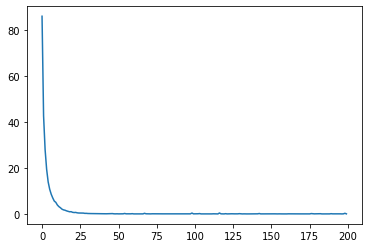

In [ ]:
import matplotlib.pyplot as plt

plt.plot(epochs, costs)

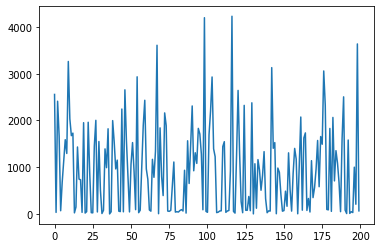

In [ ]:
plt.plot(epochs, moneys)

<h2>How did we do for the test set?</h2>

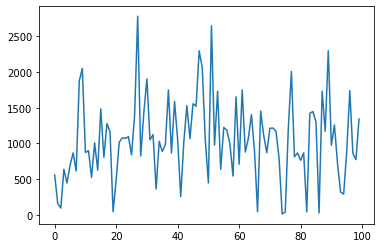

In [ ]:
# Run the model 100 times
runs, test_moneys = [], []
for i in range(100):
  runs.append(i)
  _, money = run_model(model, 1000, test_mls, test_bet_results)
  test_moneys.append(money)
plt.plot(runs, test_moneys)

<h2>Save model so we can run it later in the API</h2>

To save the model all we really need to do is output our logits weights. 

In [ ]:
saver = tf.train.Saver()

saver.save(model.sess, 'out/my-checkpoints')

!zip out -r reinforcement_saved.zip out/

	zip warning: name not matched: reinforcement_saved.zip
  adding: out/ (stored 0%)
  adding: out/my-checkpoints.meta (deflated 86%)
  adding: out/my-checkpoints.data-00000-of-00001 (deflated 7%)
  adding: out/checkpoint (deflated 48%)
  adding: out/my-checkpoints.index (deflated 32%)
